collaborative filtering - enables us to make unique, personalized recommendations for each customer and each product

## Popularity-Based Recommendations

- The dilemma of needing to make intelligent recommendations without any specific knowledge about the customer is referred to as the cold-start problem.
    - -> reasonable step is to recommend most popular item

In [6]:
import pandas as pd
import numpy as np
interaction=pd.read_csv('https://bradfordtuckfield.com/purchasehistory1.csv')
interaction.set_index("Unnamed: 0", inplace = True)
print(interaction)

            user1  user2  user3  user4  user5
Unnamed: 0                                   
item1           1      1      0      1      1
item2           1      0      1      1      0
item3           1      1      0      1      1
item4           1      0      1      0      1
item5           1      1      0      0      1


interaction matrix - it represents information about interactions between users and items

In [7]:
interaction_withcounts=interaction.copy()
interaction_withcounts.loc[:,'counts']=interaction_withcounts.sum(axis=1)
interaction_withcounts=interaction_withcounts.sort_values(by='counts',ascending=False)
print(list(interaction_withcounts.index))

['item1', 'item3', 'item2', 'item4', 'item5']


In [8]:
# function that generates popularity-based recs for any interaction matrix
def popularity_based(interaction):
    interaction_withcounts=interaction.copy()
    interaction_withcounts.loc[:,'counts']=interaction_withcounts.sum(axis=1)
    sorted = interaction_withcounts.sort_values(by='counts',ascending=False)
    most_popular=list(sorted.index)
    return(most_popular)

In [5]:
print(popularity_based(interaction))

['item1', 'item3', 'item2', 'item4', 'item5']


## Item-Based Colloborative Filtering

item-based collaborative filtering: if a user is interested in an item, recommend to that customer other items whose purchase histories have the most in common with the item they’re interested in

In [9]:
# Measuring Vector Similarity

print(list(interaction.loc['item1',:]))
# row of a matrix = vector

[1, 1, 0, 1, 1]


If want to find a quantitative measurement that signifies exactly how similar the two vectors are, all we need to do is measure the angle between the two vectors.
- If the angle theta is small, we conclude that the two vectors are similar. 
- If theta is large, we conclude that the two vectors are very different. 

The smallest possible angle between two vectors is 0; a 0-degree angle between two vectors means that they’re pointing in exactly the same direction (they overlap).

The cosine is important because we can use it to measure the similarity of two vectors. 
- If two vectors are similar, the angle between them will be small, so the cosine of the angle between them will be large (1 or close to 1). 
- If two vectors are perpendicular, they’re quite different, and the cosine of the angle between them will be 0.

cosine similarity: the cosine of the angle between the vectors

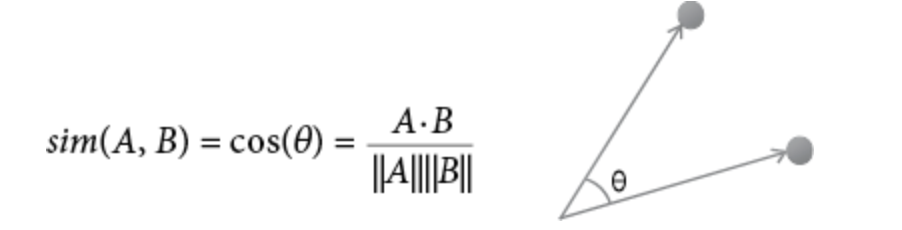

In [11]:
# Calculating Cosine Similarity

# dot product - multiply vectors together; A·B
def dot_product(vector1,vector2):
    thedotproduct=np.sum([vector1[k]*vector2[k] for k in range(0,len(vector1))])
    return(thedotproduct)

In [12]:
# pipe symbols (||) indicates the respective sizes of vectors A⃗ and B⃗, also called their vector norms
def vector_norm(vector):
    thenorm=np.sqrt(dot_product(vector,vector))
    return(thenorm)

In [13]:
def cosine_similarity(vector1,vector2):
    thedotproduct=dot_product(vector1,vector2)
    thecosine=thedotproduct/(vector_norm(vector1)*vector_norm(vector2))
    thecosine=np.round(thecosine,4)
    return(thecosine)

In [14]:
import numpy as np
item1=interaction.loc['item1',:]
item3=interaction.loc['item3',:]
print(cosine_similarity(item1,item3))
# angle between these vectors is 0-> identical vectors

1.0


In [15]:
item2=list(interaction.loc['item2',:])
item5=list(interaction.loc['item5',:])
print(cosine_similarity(item2,item5))
# angle between these vectors is about 71 degrees -> different vectors

0.3333


In [17]:
item3=list(interaction.loc['item3',:])
print(cosine_similarity(item3,item5))
# very similar vectors but not identical

0.866


In [19]:
# Implementing Item-Based Collaborative Filtering

# defining vectors
ouritem='item1'
otherrows=[rowname for rowname in interaction.index if rowname!=ouritem]
otheritems=interaction.loc[otherrows,:]
theitem=interaction.loc[ouritem,:]

# calculate how similar each item is to selected item and recommend similar items
similarities=[]
for items in otheritems.index:
    similarities.append(cosine_similarity(theitem,otheritems.loc[items,:]))

otheritems['similarities']=similarities
recommendations = list(otheritems.sort_values(by='similarities',ascending=False).index)

print(recommendations)

['item3', 'item5', 'item2', 'item4']


In [20]:
# consolidated function

def get_item_recommendations(interaction,itemname):
    otherrows=[rowname for rowname in interaction.index if rowname!=itemname]
    otheritems=interaction.loc[otherrows,:]
    theitem=list(interaction.loc[itemname,:])
    similarities=[]
    for items in otheritems.index:
        similarities.append(cosine_similarity(theitem,list(otheritems.loc[items,:])))
    otheritems['similarities']=similarities
    return list(otheritems.sort_values(by='similarities',ascending=False).index)

In [21]:
get_item_recommendations(interaction, 'item1')

['item3', 'item5', 'item2', 'item4']

## User-Based Collaborative Filtering

user-based collaborative filtering: based on the idea that people who are similar may be interested in the same items

In [22]:
user2=interaction.loc[:,'user2']
user5=interaction.loc[:,'user5']
print(cosine_similarity(user2,user5))

0.866


In [23]:
user3=interaction.loc[:,'user3']
print(cosine_similarity(user3,user5))

0.3536


In [24]:
def get_similar_users(interaction,username):
    '''This function takes a customer name and an interaction matrix as its inputs. It calculates the similarity of 
    the input customer to all other customers specified in the interaction matrix. The final output is a ranked list 
    of customers, sorted from the most similar customer to the least similar customer.'''
    othercolumns=[columnname for columnname in interaction.columns if columnname!=username]
    otherusers=interaction[othercolumns]
    theuser=list(interaction[username])
    similarities=[]
    for users in otherusers.columns:
        similarities.append(cosine_similarity(theuser,list(otherusers.loc[:,users])))
    otherusers.loc['similarities',:]=similarities
    return list(otherusers.sort_values(by='similarities',axis=1,ascending=False).columns)

In [25]:
def get_user_recommendations(interaction,username):
    '''Calculate how similar every user is to user5.
        Rank customers from most similar to least similar to user5.
        Find the most similar customer to user5.
        Recommend everything the most similar customer has purchased that user5 has not purchased.'''
    similar_users=get_similar_users(interaction,username)
    purchase_history=interaction[similar_users[0]]
    purchased=list(purchase_history.loc[purchase_history==1].index)
    purchased2=list(interaction.loc[interaction[username]==1,:].index)
    recs=sorted(list(set(purchased) - set(purchased2)))
    return(recs)

In [26]:
get_user_recommendations(interaction,'user2')

/var/folders/q0/mqxr4sbx0kq4j_t6_kt3k58h0000gp/T/ipykernel_13272/3941746398.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  otherusers.loc['similarities',:]=similarities


['item4']

## Case Study: Music Recommendations

In this case, the “items” in our interaction matrix will be musical artists, and a 1 in the interaction matrix will indicate that a user has listened to an artist.

In [28]:
import pandas as pd
lastfm = pd.read_csv("https://bradfordtuckfield.com/lastfm-matrix-germany.csv")
print(lastfm.head())

   user  a perfect circle  abba  ac/dc  adam green  aerosmith  afi  air  \
0     1                 0     0      0           0          0    0    0   
1    33                 0     0      0           1          0    0    0   
2    42                 0     0      0           0          0    0    0   
3    51                 0     0      0           0          0    0    0   
4    62                 0     0      0           0          0    0    0   

   alanis morissette  alexisonfire  ...  timbaland  tom waits  tool  \
0                  0             0  ...          0          0     0   
1                  0             0  ...          0          0     0   
2                  0             0  ...          0          0     0   
3                  0             0  ...          0          0     0   
4                  0             0  ...          0          0     0   

   tori amos  travis  trivium  u2  underoath  volbeat  yann tiersen  
0          0       0        0   0          0        

In [29]:
lastfm.drop(['user'],axis=1,inplace=True)
print(lastfm.head())

   a perfect circle  abba  ac/dc  adam green  aerosmith  afi  air  \
0                 0     0      0           0          0    0    0   
1                 0     0      0           1          0    0    0   
2                 0     0      0           0          0    0    0   
3                 0     0      0           0          0    0    0   
4                 0     0      0           0          0    0    0   

   alanis morissette  alexisonfire  alicia keys  ...  timbaland  tom waits  \
0                  0             0            0  ...          0          0   
1                  0             0            0  ...          0          0   
2                  0             0            0  ...          0          0   
3                  0             0            0  ...          0          0   
4                  0             0            0  ...          0          0   

   tool  tori amos  travis  trivium  u2  underoath  volbeat  yann tiersen  
0     0          0       0        0   0 

In [33]:
# “To make sure our interaction matrix can work with our functions, we should transpose it, or rewrite its rows as columns and its columns as rows:
lastfmt=lastfm.T
print(lastfmt.head())

                  0     1     2     3     4     5     6     7     8     9     \
a perfect circle     0     0     0     0     0     0     0     0     0     0   
abba                 0     0     0     0     0     0     0     0     0     0   
ac/dc                0     0     0     0     0     0     0     0     0     0   
adam green           0     1     0     0     0     0     0     0     0     0   
aerosmith            0     0     0     0     0     0     0     0     0     0   

                  ...  1247  1248  1249  1250  1251  1252  1253  1254  1255  \
a perfect circle  ...     0     0     0     1     0     0     0     0     0   
abba              ...     0     0     0     0     0     0     0     0     0   
ac/dc             ...     0     0     0     0     0     1     0     1     0   
adam green        ...     0     0     0     0     0     1     0     0     0   
aerosmith         ...     0     0     0     0     0     1     0     0     0   

                  1256  
a perfect circle   

In [32]:
print(lastfmt.shape)

(285, 1257)


In [34]:
get_item_recommendations(lastfmt,'abba')[0:10]

['madonna',
 'robbie williams',
 'elvis presley',
 'michael jackson',
 'queen',
 'the beatles',
 'kelly clarkson',
 'groove coverage',
 'duffy',
 'mika']

In [35]:
print(get_user_recommendations(lastfmt,0)[0:3])

/var/folders/q0/mqxr4sbx0kq4j_t6_kt3k58h0000gp/T/ipykernel_13272/3106437064.py:3: RuntimeWarning: invalid value encountered in true_divide
  thecosine=thedotproduct/(vector_norm(vector1)*vector_norm(vector2))
/var/folders/q0/mqxr4sbx0kq4j_t6_kt3k58h0000gp/T/ipykernel_13272/3941746398.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  otherusers.loc['similarities',:]=similarities


['billy talent', 'bob marley', 'die toten hosen']


## Generating Recommendations with Advanced Systems

Several other techniques allow generation of intelligent recommendations. 
- One approach, called singular value decomposition, relies on matrix algebra to decompose the interaction matrix into several smaller matrices. 
    - These smaller matrices can be multiplied in various ways to predict which products will appeal to which customers. 
    - Singular-value decomposition is one of several methods that use linear algebra to predict customer preferences. 
- Another such linear algebra method is called alternating least squares.

Clustering-based Recommendations:
- Generate clusters of users
- Find the most popular items in each cluster of users
- Recommend those popular items, but only within each cluster

Attribute-based systems (also called content-based recommender systems): This is an item-based recommendation system, but instead of using purchase histories, it uses item attributes to find relevant recommendations.

In a popularity-based system, dates or timestamps can enable you to replace all-time most popular lists with today’s most popular lists, or lists that show trending content across the most recent hour, week, or any other time frame.

Intersting Idea: "You may also need to build recommendation systems with interaction matrices that are not 0/1 matrices. For example, you could have an interaction matrix whose entries indicate the number of times a song has been played, rather than a 0/1 indicator of whether a song has been played. You might also find an interaction matrix that contains ratings rather than interactions.”